In [73]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from lrfinder import LRFinder

# Import the Desired Version of EfficientNet
from tensorflow.keras.applications import EfficientNetB0

In [74]:
DATA_DIR = "data_original/"
NEW_DATA_DIR = "data/"

In [75]:
train_path = os.path.join(NEW_DATA_DIR,"train/")
valid_path = os.path.join(NEW_DATA_DIR,"valid/")
test_path = os.path.join(NEW_DATA_DIR,"test/")


In [76]:
train_batches = ImageDataGenerator( preprocessing_function=tf.keras.applications.efficientnet.preprocess_input).flow_from_directory(
        directory=train_path,shuffle=True, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input).flow_from_directory(
        directory=valid_path, shuffle=True, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input).flow_from_directory(
        directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)
    

Found 933 images belonging to 4 classes.
Found 231 images belonging to 4 classes.
Found 626 images belonging to 4 classes.


In [77]:

NUM_CLASSES = 4
EPOCHS = 10

In [78]:
img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1),
        preprocessing.CenterCrop(224,224)
    ],
    name="img_augmentation",
)

In [79]:
def build_model(NUM_CLASSES):
    inputs = layers.Input(shape=(224, 224, 3))
    x = img_augmentation(inputs)
    #Using the imported version of EfficientNet
    model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")
    # Freeze the pretrained weights
    model.trainable = False


    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3, name="top_dropout_1")(x)
    x = layers.Dense(512, name = "top_dense")(x)
    x = layers.Dropout(0.2, name="top_dropout_2")(x)
    x = layers.LeakyReLU( name="top_actviation")(x)
 
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam()
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model



In [80]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam()
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    

In [81]:
model = build_model(NUM_CLASSES)

In [82]:
#model compile
unfreeze_model(model)

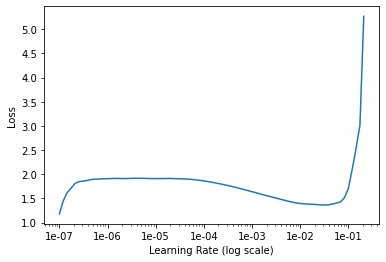

In [83]:
lr_finder = LRFinder()
_ = model.fit(train_batches, epochs=5, callbacks=[lr_finder], verbose=False)
lr_finder.plot()
